In [1]:
import numpy as np
import pandas as pd

In [2]:
descrips = pd.read_csv('descriptions.csv')
print(len(descrips), descrips.beer_id.nunique())

114347 114347


In [3]:
checkins = pd.read_csv('comboframe.csv', usecols=['beer_id', 'rating_user',
                                                  'rating_global', 'user_id',
                                                  'abv', 'brewery_name',
                                                  'beer_style', 'beer_name'])

checkins.shape

(2061965, 8)

In [4]:
checkins.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)
checkins.shape

(1894852, 8)

In [7]:
checkins = checkins.merge(descrips, how='inner')
checkins.shape

(1394388, 9)

In [8]:
# cut the non-globally rated, which are only 2% of the data
checkins.dropna(subset=['rating_global'], axis=0, inplace=True)

In [9]:
sum(checkins.rating_global == 0)

2488

In [10]:
# get rid of those, too
checkins = checkins[checkins.rating_global > 0]
checkins.shape

(1366604, 9)

In [11]:
by_beer = checkins.groupby('beer_id')

descrips['abv'] = descrips.beer_id.map(dict(by_beer['abv'].mean()))
descrips['rating_global'] = descrips.beer_id.map(dict(by_beer['rating_global'].mean()))

In [12]:
droppers = descrips.rating_global == 0
sum(droppers)

0

In [13]:
sum(descrips.rating_global.isna())

1377

In [14]:
droppers = descrips.rating_global.isna()

In [15]:
descrips = descrips[~droppers]
len(descrips)

112970

In [16]:
descrips['brewery_name'] = descrips.beer_id.map(dict(by_beer['brewery_name'].max(key=len)))
descrips['beer_name'] = descrips.beer_id.map(dict(by_beer['beer_name'].max(key=len)))
descrips['beer_style'] = descrips.beer_id.map(dict(by_beer['beer_style'].max(key=len)))

In [17]:
descrips['beer_description'] = descrips.brewery_name + ' ' + descrips.beer_name + ' ' + descrips.beer_description

In [18]:
descrips.head()

,beer_id,beer_description,abv,rating_global,brewery_name,beer_name,beer_style
0,2095023,Stone Brewing Stone Scorpion Bowl IPA To creat...,7.5,3.73789,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American
1,2734572,Ritual Brewing Company Oil Rig NEW TRADITIONS ...,9.0,3.87873,Ritual Brewing Company,Oil Rig,IPA - Imperial / Double
2,1044097,Stone Brewing Stone Ruination Double IPA 2.0 S...,8.5,4.01290,Stone Brewing,Stone Ruination Double IPA 2.0,IPA - Imperial / Double
3,1070,Lagunitas Brewing Company Imperial Stout Made ...,9.9,3.91420,Lagunitas Brewing Company,Imperial Stout,Stout - Russian Imperial
4,490277,Pizza Port Brewing Company Swami's IPA Note: S...,6.8,3.84851,Pizza Port Brewing Company,Swami's IPA,IPA - American


In [19]:
print(len(checkins))
fiveplus = checkins.groupby('user_id').size() > 4
checkins = checkins[checkins.user_id.map(fiveplus)]
print(len(checkins))
checkins.user_id.nunique()

1366604
1037030


19264

In [20]:
checkins.groupby('user_id').size().min()

5

In [21]:
descrips.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            114337, 114338, 114339, 114340, 114341, 114342, 114343, 114344,
            114345, 114346],
           dtype='int64', length=112970)

In [22]:
descrips.reset_index(inplace=True)

In [23]:
descrips.index

RangeIndex(start=0, stop=112970, step=1)

In [24]:
# so that the descrips/vecs index can be looked up for each beer_id
beer_id_to_vecs_index = dict(zip(descrips.beer_id, descrips.index))

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm

In [27]:
cv = CountVectorizer(stop_words='english', min_df=10, max_df=0.17, binary=True)
vecs = cv.fit_transform(descrips.beer_description)
vecs.shape

(112970, 14937)

In [28]:
from scipy.sparse import hstack, csr_matrix
# add scaled abv column, unscaled global rating col, and style one-hot col
vecs = hstack([vecs, descrips.abv.values[:, np.newaxis] / 5.0])
vecs = hstack([vecs, descrips.rating_global.values[:, np.newaxis]])
ohe = OneHotEncoder(sparse=True)
styles = ohe.fit_transform(descrips.beer_style.values.reshape(1, -1))
vecs = hstack([vecs, styles.transpose()])
vecs = csr_matrix(vecs)

In [29]:
vecs.shape

(112970, 14940)

In [50]:
def user_rating_target(model, df, wordvecs, beer_2_vec_map, last_x=1, rando=0):
    '''
    Train sklearn.SGDRegressor on all but last one, or more, of
    each User's profile of checkins, chronologically, and then
    test on the most recent one(s).
    --------------
    Inputs--
    
    model: sklearn-style that can fit on (trainX, trainY) and predict on testX.
    
    df: has columns indicating the user's ratings biases.
        (Training will only use the biases calculated on train data.)
        
    wordvecs: feature matrix, a sparse csr_matrix of binary encoded
        bag-of-words filled from the beer name, brewery name, and textual
        description of the beer, provided by brewery.  Also featured are 
        the scaled abv (alc. by vol.) content of each beer, and a binary 
        category for the beer's style, as well as the beer's global_rating.
        
    beer_2_vec_map:  converts the df's beer ID to wordvecs row index
    
    last_x:  how many rows to use for testing.  defaults to 1, the most recent checkin.
    
    rando:  random seed for the SGD model
    --------------
    Returns-- a dict mapping User ID to a tuple of rmse errors, (baseline, trained_model).
    
    '''
    
    scores = dict()
    
    # Loop over each user in the DataFrame input
    for u in tqdm(df.user_id.unique()):
        udf = df[df.user_id == u]
        ratings = len(udf)
        # use the @last_x integer, default=1, of each user's checkins as the test group
        split = ratings - last_x  # (first) index of test rating(s)
        utrain = udf.iloc[:split, :]  # train-test split
        utest = udf.iloc[split:, :]
        # make the corresponding split to the vector indices, vi
        vi = udf.beer_id.map(beer_2_vec_map)
        trainvecs = wordvecs[vi[:split], :]
        testvecs = wordvecs[vi[split:], :]
        # calculate the user's avg generosity/stinginess towards KNOWN ratings, for baseline
        known_bias = (utrain.rating_user - utrain.rating_global).mean()
        # USE THE USER RATINGS AS TARGETS---DOESN'T WORK WELL THOUGH!
        train_targets = utrain.rating_user
        # train the model, stopping early when there are enough training samples to justify validating
        stop_early = len(utrain) > 10
        model.early_stopping = stop_early
        model.fit(trainvecs, train_targets)
        
        preds = model.predict(testvecs)
        preds = np.clip(preds, 0.25, 5) # possible ratings are 0.25 to 5
        
        baseline_preds = utest.rating_global + known_bias
        
        # store the baseline rmse
        diffs_base = baseline_preds - utest.rating_user
        sumsq = np.dot(diffs_base, diffs_base)
        rmse_base = np.sqrt(sumsq / len(diffs_base))
        
        # store the model rmse
        diffs_nlp = preds - utest.rating_user
        sumsq = np.dot(diffs_nlp, diffs_nlp)
        rmse_nlp = np.sqrt(sumsq / len(diffs_nlp))
        
        scores[u] = (rmse_base, rmse_nlp)
        
    return scores, model  # this model is only trained for the last User, but is returned
                            # for inspection

In [31]:
# test run
model = SGDRegressor(penalty='elasticnet', validation_fraction=0.1, 
                     random_state=rando, max_iter=700, tol=1e-5, l1_ratio=0.5)
scores = user_rating_target(checkins[(checkins.user_id == 2607740)  | 
                                     (checkins.user_id == 1040951)], 
                            vecs, beer_id_to_vecs_index)

100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


In [32]:
scores

{1040951: (0.42734569444444404, 0.51620577672500723),
 2607740: (0.13190660194174786, 0.02108419302576392)}

In [33]:
scores = user_rating_target(checkins, vecs, beer_id_to_vecs_index)

  0%|          | 29/19264 [00:13<2:14:48,  2.38it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 11%|█         | 2126/19264 [16:19<2:03:16,  2.32it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 11%|█         | 2127/19264 [16:19<2:23:57,  1.98it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 11%|█         | 2147/19264 [16:28<2:05:50,  2.27it/s]/Applications/anaconda/lib/python3.6/site-

In [34]:
np.mean([val for val in scores.values()], axis=0)  # ([baseline mean rmse , regression mean rmse])

array([ 0.30810649,  0.44666585])

##### That's pretty bad non-baseline scores.  

In [36]:
# try without the NLP, just with abv and global rating, smaller subset
np.random.seed(1)
sample500 = np.random.choice(checkins.user_id.unique(), 500)
shortvecs = csr_matrix(vecs.toarray()[:, -3:])

In [38]:
sample500_scores = user_rating_target(checkins[checkins.user_id.apply(lambda uid: uid in sample500)],
                             shortvecs, beer_id_to_vecs_index, rando=1)

 25%|██▌       | 124/489 [00:39<02:44,  2.22it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 34%|███▍      | 166/489 [00:51<01:28,  3.64it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 37%|███▋      | 181/489 [00:55<01:30,  3.39it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 40%|███▉      | 194/489 [01:00<01:24,  3.48it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/l

In [39]:
np.mean([val for val in sample500_scores.values()], axis=0)  # ([baseline mean rmse , regression mean rmse])

array([ 0.30772315,  0.31266795])

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
gbr = GradientBoostingRegressor()
gbr_scores = user_rating_target(gbr, checkins[checkins.user_id.apply(lambda uid: uid in sample500)],
                                vecs, beer_id_to_vecs_index, rando=1)

100%|██████████| 489/489 [04:45<00:00,  2.50it/s]


In [46]:
np.mean([val for val in gbr_scores.values()], axis=0)

array([ 0.30772315,  0.33740359])

In [53]:
# inspect the fail:
sgd = SGDRegressor(penalty='elasticnet', validation_fraction=0.1, 
                     random_state=0, max_iter=700, tol=1e-5, l1_ratio=0.5)
rand_user = 8
err, mod = user_rating_target(sgd, checkins[checkins.user_id == checkins.loc[checkins.index[rand_user], 'user_id']],
                              vecs, beer_id_to_vecs_index)


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


In [54]:
err

{4293928: (0.44561298507462732, 0.26948273567078251)}

So in this one randomly sampled User's case, the baseline underperformed the trained model.  Let's see how the model  
gained this advantage:

In [71]:
# how many checkins did this user have to train on?
u = checkins.loc[checkins.index[rand_user], 'user_id']
udf = checkins[checkins.user_id == u]
len(udf)

135

In [63]:
# what were the words that were so helpful in beating the baseline?
checkins[checkins.user_id == u].tail(3)

,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description
287880,3072594,4293928,3.00,Liquid Shoes Brewing,Wanna Peach of This?,Blonde Ale,3.64286,4.3,Peach Blonde with subtle peach taste
287881,936080,4293928,5.00,Iron Flamingo Brewery,IPA,IPA - American,3.43176,6.7,Iron Flamingo’s I.P.A. balances four types of ...
287884,3110787,4293928,3.25,Liquid Shoes Brewing,"Same Number, Same Hood IPA",IPA - New England,3.86520,7.0,Made with El Dorado & Idaho 7


In [58]:
# how many weights didn't get pushed to zero?
len(np.nonzero(mod.coef_)[0])

1411

In [72]:
# and how many of the terms in the single test rating were in those 1411?
lastbeerID = udf.loc[udf.index[-1], 'beer_id']
vect = beer_id_to_vecs_index[lastbeerID]
vect = vecs.toarray()[vect, :]

In [73]:
np.nonzero(vect)

(array([ 4234,  4552,  6654,  6830,  7900,  9246, 11918, 14937, 14938, 14939]),)

In [81]:
print([cv.get_feature_names()[word] for word in np.nonzero(vect)[0][:-3]]) # last 3 are non-text

['dorado', 'el', 'hood', 'idaho', 'liquid', 'number', 'shoes']


In [82]:
coefs = [mod.coef_[x] for x in np.nonzero(vect)[0][:-3]]
print(sorted(list(zip(coefs, [cv.get_feature_names()[word]
                              for word in np.nonzero(vect)[0][:-3]])),
             key=lambda tup: abs(tup[0]), reverse=True))

[(0.039057384582378937, 'liquid'), (0.039057384582378937, 'shoes'), (-0.026369786865277987, 'dorado'), (-0.026369786865277987, 'el'), (0.015383113996929825, 'idaho'), (0.0, 'hood'), (0.0, 'number')]


In [83]:
# last 3:
mod.coef_[-3:]

array([ 0.28062598,  0.74933809,  0.18762883])

In [84]:
vect[-3:] # [abv / 5.0, global_rating, style category]

array([ 1.4   ,  3.8652,  1.    ])

In [85]:
np.multiply(mod.coef_[-3:], vect[-3:])

array([ 0.39287638,  2.89634158,  0.18762883])

In [86]:
# User's known tendency
np.mean(udf.rating_user[:-1] - udf.rating_global[:-1])

-0.16958701492537306

This prediction is getting +0.39 of its score from the abv, +2.9 from the global mean, and +0.19 from the beer style.  The words in the description barely counted for anything (about +0.04), so the model predicted about 3.5 for this rating, vs. the 3.25 the user actually rated, as evidenced by the 0.27 RMSE.  Meanwhile, the baseline took the beer's 3.87 global mean, subtracted the 0.17 negative bias of the User, and predicted 3.7, so performed worse.  

In [91]:
dorados = udf.beer_description.str.contains('Dorado')

In [92]:
sum(dorados)  

6

In [95]:
udf[dorados]

,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description
161880,1940001,4293928,3.00,Orono Brewing Company,Tubular IPA,IPA - New England,4.02575,7.2,"Triple dry-hopped and juicy. Tropical, stone f..."
163005,1885153,4293928,3.75,Other Half Brewing Co.,Double Dry Hopped Mylar Bags,IPA - Imperial / Double,4.45879,8.5,Our standard Mylar Bags which is hopped with A...
166596,2659689,4293928,3.50,LIC Beer Project,Unicorn Apocalypse,IPA - Imperial / Double,4.11360,8.5,Brewed with a blend of two malted oat varietie...
235878,1623579,4293928,3.25,LIC Beer Project,Higher Burnin',IPA - American,4.02778,7.0,"Brewed with late additions of Belma, El Dorado..."
287820,2398504,4293928,4.50,K2 Brothers Brewing,DDH Double IPA,IPA - Imperial / Double,3.90654,8.0,Our Double Dry-Hopped NE-Style IPA is fruit fo...
287884,3110787,4293928,3.25,Liquid Shoes Brewing,"Same Number, Same Hood IPA",IPA - New England,3.86520,7.0,Made with El Dorado & Idaho 7


Perhaps the -0.052 the model deducted from its prediction due to "El Dorado" hops being in the test beer was in fact justified by the ratings for the previous 5 beers with El Dorado hops.

In [100]:
np.mean(udf[dorados].rating_user[:-1] - udf[dorados].rating_global[:-1])

-0.5064920000000002

How bout a handpicked list of hops and adjectives?

In [102]:
hops = ['galaxy','citra','mosaic','amarillo','nelson','columbus','cascade',
        'hallertau','nugget','motueka','centennial','goldings','rakau','idaho',
        'willamette','azacca','bravo','bru','cashmere','chinook','ctz','dorado',
        'sorachi','hbc','medusa','pekko','sterling','strata','summit','warrior',
        'ekuanot','sabro','zappa']
terms = ['yeast','oil','hash','powder','malt','grain','pineapple','coconut','stonefruit',
        'fruit','fruits','citrus','peach','peaches','lemon','lemons','grapefruit','grapefruits',
         'zest','pith','peel','candy','hop','hops','orange','oranges','marmelade','jam','rind',
        'lime','limes','melon','melons','juice','oak','neipa','east','west','hemisphere','pacific']
adjs = ['fruity','tropical','dank','oily','resinous','bitter','sweet','malty','yeasty','fresh',
       'juicy','concentrated','hoppy','dry','hopped','ddh','tdh','hopping','intense','aromatic',
       'whirlpool','full','double','triple','rich','creamy','dark','sour','oaky','light','ripe',
       'overripe','green','red','black','white','stout','ipa','dipa','iipa','american']

my_cv = CountVectorizer(vocabulary=hops+terms+adjs, binary=True)

my_vecs = my_cv.fit_transform(descrips.beer_description)
my_vecs.shape

In [108]:
my_vecs = hstack([my_vecs, descrips.abv.values[:, np.newaxis] / 5.0])
my_vecs = hstack([my_vecs, descrips.rating_global.values[:, np.newaxis]])
#ohe = OneHotEncoder(sparse=True)
#styles = ohe.fit_transform(descrips.beer_style.values.reshape(1, -1))
my_vecs = hstack([my_vecs, styles.transpose()])
my_vecs = csr_matrix(my_vecs)

In [111]:
sgd = SGDRegressor(penalty='elasticnet', validation_fraction=0.1, 
                     random_state=0, max_iter=700, tol=1e-5, l1_ratio=0.5)
sample500_scores, model500 = user_rating_target(sgd, checkins[checkins.user_id.apply(lambda uid: uid in sample500)],
                             my_vecs, beer_id_to_vecs_index, rando=1)

 38%|███▊      | 184/489 [00:48<01:16,  3.99it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 40%|████      | 197/489 [00:52<01:13,  3.99it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 41%|████      | 199/489 [00:52<01:12,  4.00it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 42%|████▏     | 206/489 [00:55<01:28,  3.20it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/l

In [112]:
np.mean([val for val in sample500_scores.values()], axis=0)  # ([baseline mean rmse , regression mean rmse])

array([ 0.30772315,  0.33609276])

Now use User preference per rating as the target, so get rid of global rating column

In [118]:
my_vecs = my_cv.fit_transform(descrips.beer_description)
my_vecs = hstack([my_vecs, descrips.abv.values[:, np.newaxis] / 5.0])
my_vecs = hstack([my_vecs, styles.transpose()])
my_vecs = csr_matrix(my_vecs)

In [145]:
def test_last(model, df, wordvecs, beer_2_vec_map, last_x=1, rando=0):
    '''
    @df input has columns indicating the user's ratings biases,
    but the training will only use the biases calculated on itself.
    '''
    # keep scores in this dict
    scores = dict()
    
    for u in tqdm(df.user_id.unique()):
        udf = df[df.user_id == u]
        ratings = len(udf)
        # use the @last_x of each user's checkins as the test group
        split = ratings - last_x
        utrain = udf.iloc[:split, :]
        utest = udf.iloc[split:, :]
        # make the corresponding split to the vector indices, vi
        vi = udf.beer_id.map(beer_2_vec_map)
        trainvecs = wordvecs[vi[:split], :]
        testvecs = wordvecs[vi[split:], :]
        # calculate the user's avg generosity/stinginess towards KNOWN ratings
        utrain['beer_bias'] = utrain.rating_user - utrain.rating_global
        known_bias = utrain.beer_bias.mean()
        # HERE WE TARGET THE USER DEVIATION FROM MEAN BIAS PER BEER
        train_targets = utrain.beer_bias - known_bias
        
        stop_early = len(utrain) > 10
        model = SGDRegressor(penalty='elasticnet', early_stopping=stop_early, validation_fraction=0.1, 
                     random_state=rando, max_iter=500, tol=1e-5, l1_ratio=0.5)
        model.fit(trainvecs, train_targets)
        
        preds = model.predict(testvecs)
        baseline_preds = utest.rating_global + known_bias
        # HERE THE NLP PREDICTION IS GRADUALLY MIXED IN
        nlp_preds = (0.3 + 0 / trainvecs.shape[0]) * preds + baseline_preds
        
        diffs_base = baseline_preds - utest.rating_user
        sumsq = np.dot(diffs_base, diffs_base)
        rmse_base = np.sqrt(sumsq / len(diffs_base))
        
        diffs_nlp = nlp_preds - utest.rating_user
        sumsq = np.dot(diffs_nlp, diffs_nlp)
        rmse_nlp = np.sqrt(sumsq / len(diffs_nlp))
        
        scores[u] = (rmse_base, rmse_nlp)
        
    return scores, model

In [141]:
sc, m = test_last(sgd, checkins[checkins.user_id.apply(lambda uid: uid in sample500)],
                             my_vecs, beer_id_to_vecs_index, rando=1)

  0%|          | 0/489 [00:00<?, ?it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 1/489 [00:00<05:52,  1.38it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 2/489 [00:00<04:46,  1.70it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [142]:
np.mean([val for val in sc.values()], axis=0) 

array([ 0.30772315,  0.3072205 ])

In [146]:
sc, m = test_last(sgd, checkins[checkins.user_id.apply(lambda uid: uid in sample501)],
                             my_vecs, beer_id_to_vecs_index, rando=1)

  0%|          | 0/496 [00:00<?, ?it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 1/496 [00:01<08:52,  1.08s/it]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 2/496 [00:01<06:54,  1.19it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [147]:
np.mean([val for val in sc.values()], axis=0)

array([ 0.30334944,  0.30742524])

In [125]:
sgd = SGDRegressor(penalty='elasticnet', validation_fraction=0.1, 
                     random_state=0, max_iter=700, tol=1e-5, l1_ratio=0.5)
rand_user = 8
err, mod = test_last(sgd, checkins[checkins.user_id == checkins.loc[checkins.index[rand_user], 'user_id']],
                              my_vecs, beer_id_to_vecs_index)

  0%|          | 0/1 [00:00<?, ?it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


In [126]:
err

{4293928: (0.44561298507462732, 0.41769775063550219)}

In [127]:
# how many weights didn't get pushed to zero?
len(np.nonzero(mod.coef_)[0])

82

In [129]:
# and how many of the terms in the single test rating were in those 1411?
lastbeerID = udf.loc[udf.index[-1], 'beer_id']
vect = beer_id_to_vecs_index[lastbeerID]
vect = my_vecs.toarray()[vect, :]

In [130]:
np.nonzero(vect)

(array([ 13,  21, 110, 114, 115]),)

In [132]:
print([my_cv.get_feature_names()[word] for word in np.nonzero(vect)[0][:-2]]) # last 2 are non-text

['idaho', 'dorado', 'ipa']


In [133]:
coefs = [mod.coef_[x] for x in np.nonzero(vect)[0][:-3]]
print(sorted(list(zip(coefs, [my_cv.get_feature_names()[word]
                              for word in np.nonzero(vect)[0][:-3]])),
             key=lambda tup: abs(tup[0]), reverse=True))

[(-0.028109261639928947, 'dorado'), (0.011574617611598359, 'idaho')]


Have a look at the errors plot

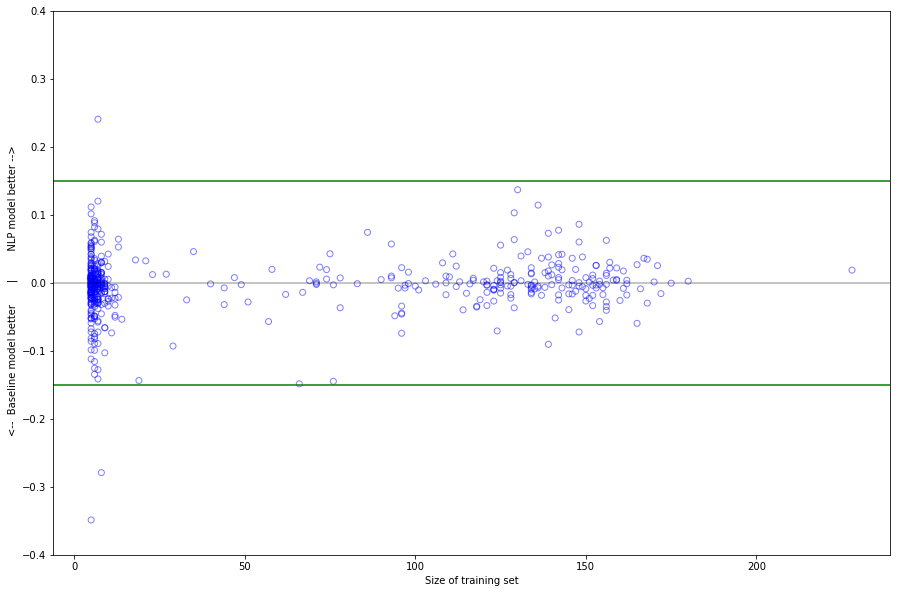

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline

sizes = dict(checkins.groupby('user_id').size())
by_size = [sizes[key] for key in sc.keys()]  # sc was the scoredict returned by test_last()
baselines = [v[0] for v in sc.values()]
nlps = [v[1] for v in sc.values()]

# assertion test
assert(len(by_size) == len(baselines) == len(nlps))

plt.figure(figsize=(15, 10))
plt.scatter(by_size, np.array(baselines) - np.array(nlps), facecolors='none', edgecolors='b', alpha=0.5)
plt.axhline(0.15, c='g')
plt.axhline(-0.15, c='g')
plt.axhline(0, c='k', alpha=0.3)
plt.ylabel('<--  Baseline model better       | \
        NLP model better -->     ')
plt.xlabel('Size of training set')
plt.ylim(-0.4, 0.4);

There are signs that the baseline works better with fewer examples, say less than 100, and then maybe the NLP model does better above that.  We can adjust the mix for that.

In [158]:
def mix(model, df, wordvecs, beer_2_vec_map, last_x=1, rando=0):
    '''
    @df input has columns indicating the user's ratings biases,
    but the training will only use the biases calculated on itself.
    '''
    # keep scores in this dict
    scores = dict()
    
    for u in tqdm(df.user_id.unique()):
        udf = df[df.user_id == u]
        ratings = len(udf)
        # use the @last_x of each user's checkins as the test group
        split = ratings - last_x
        utrain = udf.iloc[:split, :]
        utest = udf.iloc[split:, :]
        # make the corresponding split to the vector indices, vi
        vi = udf.beer_id.map(beer_2_vec_map)
        trainvecs = wordvecs[vi[:split], :]
        testvecs = wordvecs[vi[split:], :]
        # calculate the user's avg generosity/stinginess towards KNOWN ratings
        utrain['beer_bias'] = utrain.rating_user - utrain.rating_global
        known_bias = utrain.beer_bias.mean()
        # HERE WE TARGET THE USER DEVIATION FROM MEAN BIAS PER BEER
        train_targets = utrain.beer_bias - known_bias
        
        stop_early = len(utrain) > 10
        model = SGDRegressor(penalty='elasticnet', early_stopping=stop_early, validation_fraction=0.1, 
                     random_state=rando, max_iter=700, tol=1e-5, l1_ratio=0.5)
        model.fit(trainvecs, train_targets)
        
        preds = model.predict(testvecs)
        baseline_preds = utest.rating_global + known_bias
        # HERE THE NLP PREDICTION IS MIXED IN
        nlp_preds = (trainvecs.shape[0] > 100) * preds / 3 + baseline_preds
        
        diffs_base = baseline_preds - utest.rating_user
        sumsq = np.dot(diffs_base, diffs_base)
        rmse_base = np.sqrt(sumsq / len(diffs_base))
        
        diffs_nlp = nlp_preds - utest.rating_user
        sumsq = np.dot(diffs_nlp, diffs_nlp)
        rmse_nlp = np.sqrt(sumsq / len(diffs_nlp))
        
        scores[u] = (rmse_base, rmse_nlp)
        
    return scores, model

In [159]:
sc, m = mix(sgd, checkins[checkins.user_id.apply(lambda uid: uid in sample501)],
                             my_vecs, beer_id_to_vecs_index, rando=1)

  0%|          | 0/496 [00:00<?, ?it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 1/496 [00:00<05:50,  1.41it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 2/496 [00:00<04:47,  1.72it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

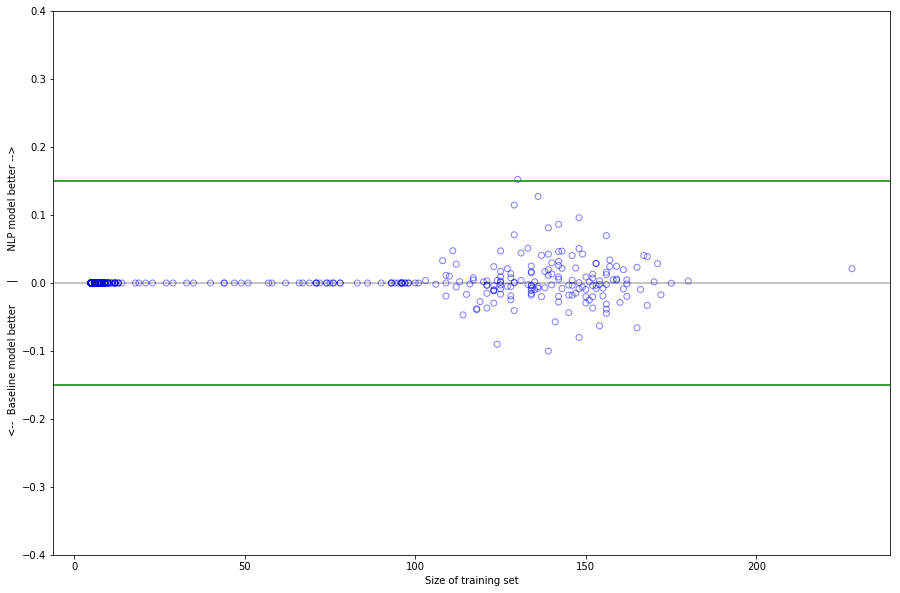

In [160]:
by_size = [sizes[key] for key in sc.keys()]  # sc was the scoredict returned above
baselines = [v[0] for v in sc.values()]
nlps = [v[1] for v in sc.values()]

plt.figure(figsize=(15, 10))
plt.scatter(by_size, np.array(baselines) - np.array(nlps), facecolors='none', edgecolors='b', alpha=0.5)
plt.axhline(0.15, c='g')
plt.axhline(-0.15, c='g')
plt.axhline(0, c='k', alpha=0.3)
plt.ylabel('<--  Baseline model better       | \
        NLP model better -->     ')
plt.xlabel('Size of training set')
plt.ylim(-0.4, 0.4);

In [161]:
np.mean([val for val in sc.values()], axis=0)

array([ 0.30334944,  0.30220133])

In [162]:
sc, m = mix(sgd, checkins[checkins.user_id.apply(lambda uid: uid in sample500)],
                             my_vecs, beer_id_to_vecs_index, rando=1)

  0%|          | 0/489 [00:00<?, ?it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 1/489 [00:00<06:07,  1.33it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 2/489 [00:01<04:59,  1.63it/s]/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

[ 0.30772315  0.30867805]


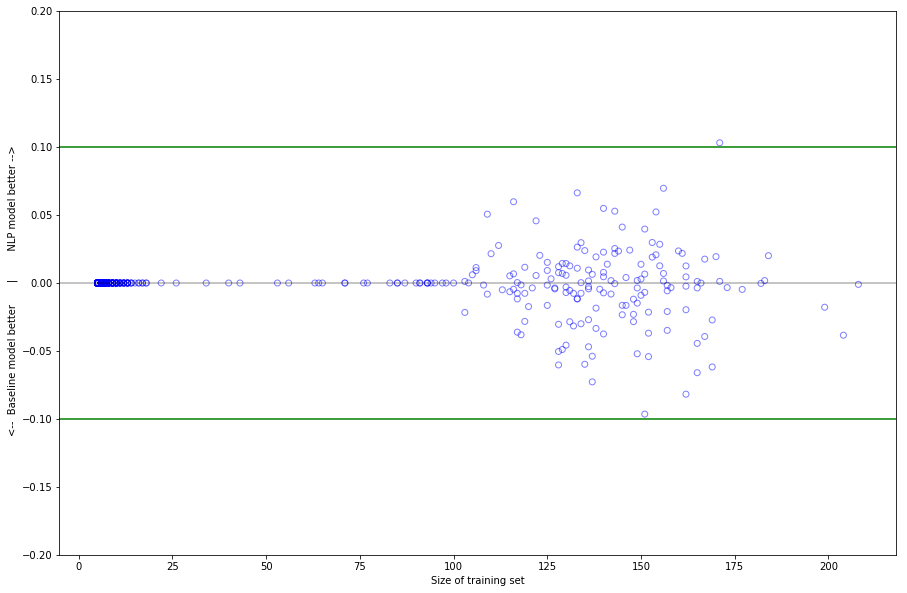

In [164]:
print(np.mean([val for val in sc.values()], axis=0))
by_size = [sizes[key] for key in sc.keys()]  # sc was the scoredict returned above
baselines = [v[0] for v in sc.values()]
nlps = [v[1] for v in sc.values()]

plt.figure(figsize=(15, 10))
plt.scatter(by_size, np.array(baselines) - np.array(nlps), facecolors='none', edgecolors='b', alpha=0.5)
plt.axhline(0.1, c='g')
plt.axhline(-0.1, c='g')
plt.axhline(0, c='k', alpha=0.3)
plt.ylabel('<--  Baseline model better       | \
        NLP model better -->     ')
plt.xlabel('Size of training set')
plt.ylim(-0.2, 0.2);